In [1]:
# Prophet Notebook
# Cell 1: imports and reproducibility
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet

warnings.filterwarnings("ignore")
seed = 42
np.random.seed(seed)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 12
os.makedirs('models_prophet', exist_ok=True)


c:\Users\ravik\Desktop\OrganicCrop-Forecast\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 2: load CSV - change filename/path as needed
csv_path = "wheat_Mysore_daily.csv"  # change to your file
df = pd.read_csv(csv_path)
print("Columns in CSV:", df.columns.tolist())
display(df.head())

# heuristics to find date & price columns
date_col = None
price_col = None
cols_lower = [c.lower() for c in df.columns]
for orig, low in zip(df.columns, cols_lower):
    if 'date' in low or 'day' in low or 'timestamp' in low:
        date_col = orig
    if 'price' in low or 'modal' in low or 'quintal' in low or 'value' in low:
        price_col = orig
if date_col is None:
    date_col = df.columns[0]
if price_col is None:
    price_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

print("Using date col:", date_col, "Using price col:", price_col)
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df[[date_col, price_col]].dropna().sort_values(by=date_col).reset_index(drop=True)
df.rename(columns={date_col: "date", price_col: "price"}, inplace=True)
df['price'] = df['price'].astype(str).str.replace(',', '').astype(float)
df.set_index('date', inplace=True)
print("Data range:", df.index.min(), "to", df.index.max())
display(df.head())


Columns in CSV: ['price date', 'modal price (rs./quintal)']


,price date,modal price (rs./quintal)
0,2020-01-01,2038.0
1,2020-01-02,2475.0
2,2020-01-03,2500.0
3,2020-01-04,2564.0
4,2020-01-05,2564.0


Using date col: price date Using price col: modal price (rs./quintal)
Data range: 2020-01-01 00:00:00 to 2024-12-05 00:00:00


,price
date,
2020-01-01,2038.0
2020-01-02,2475.0
2020-01-03,2500.0
2020-01-04,2564.0
2020-01-05,2564.0


In [3]:
# Cell 3: prepare data for Prophet (ds, y), optional fill missing dates
fill_missing_dates = True
freq = 'D'  # daily
if fill_missing_dates:
    try:
        full_idx = pd.date_range(df.index.min(), df.index.max(), freq=freq)
        df = df.reindex(full_idx)
        df['price'] = df['price'].interpolate(method='time').ffill().bfill()
        df.index.name = 'date'
    except Exception as e:
        print("Could not reindex/fill:", e)

prophet_df = df.reset_index().rename(columns={'date':'ds', 'price':'y'})[['ds','y']]
display(prophet_df.tail())


,ds,y
1796,2024-12-01,4000.0
1797,2024-12-02,4001.0
1798,2024-12-03,4001.0
1799,2024-12-04,4001.0
1800,2024-12-05,3570.0


In [4]:
# Cell 4: train Prophet model
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_df)
joblib.dump(m, 'models_prophet/prophet_model.joblib')
print("Saved Prophet model to models_prophet/prophet_model.joblib")


17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing


Saved Prophet model to models_prophet/prophet_model.joblib


In [5]:
# Cell 5: forecast next 7 and 30 days, save to CSV
h1, h2 = 7, 30
max_h = max(h1, h2)
future = m.make_future_dataframe(periods=max_h, freq='D')
forecast = m.predict(future)

last_date = prophet_df['ds'].max()
fc7 = forecast[forecast['ds'] > last_date].head(h1)[['ds','yhat','yhat_lower','yhat_upper']].copy()
fc30 = forecast[forecast['ds'] > last_date].head(h2)[['ds','yhat','yhat_lower','yhat_upper']].copy()
fc7.rename(columns={'ds':'date','yhat':'predicted'}, inplace=True)
fc30.rename(columns={'ds':'date','yhat':'predicted'}, inplace=True)

fc7.to_csv('models_prophet/prophet_forecast_7d.csv', index=False)
fc30.to_csv('models_prophet/prophet_forecast_30d.csv', index=False)
print("Saved Prophet forecasts to models_prophet/")
display(fc7.head())


Saved Prophet forecasts to models_prophet/


,date,predicted,yhat_lower,yhat_upper
1801,2024-12-06,3861.067246,2712.937060,5059.092320
1802,2024-12-07,3850.939627,2837.870636,4935.332354
1803,2024-12-08,3843.370957,2863.732069,4980.976445
1804,2024-12-09,3837.563742,2780.135540,4901.914282
1805,2024-12-10,3839.421039,2738.580865,4959.235780


In [6]:
# Cell 6: evaluate on a pseudo test (last 10% as test)
n_test = max(10, int(0.1 * len(df)))
train_df = prophet_df[:-n_test]
test_df = df[-n_test:].copy()

pm = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
pm.fit(train_df)
future_test = pm.make_future_dataframe(periods=n_test, freq='D')
pred_test = pm.predict(future_test)
pred_series = pred_test.set_index('ds')['yhat'].loc[test_df.index]

mae = mean_absolute_error(test_df['price'], pred_series)
rmse = np.sqrt(mean_squared_error(test_df['price'], pred_series))
r2 = r2_score(test_df['price'], pred_series)
print(f"Prophet MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 311.46, RMSE: 380.62, R2: -0.3571


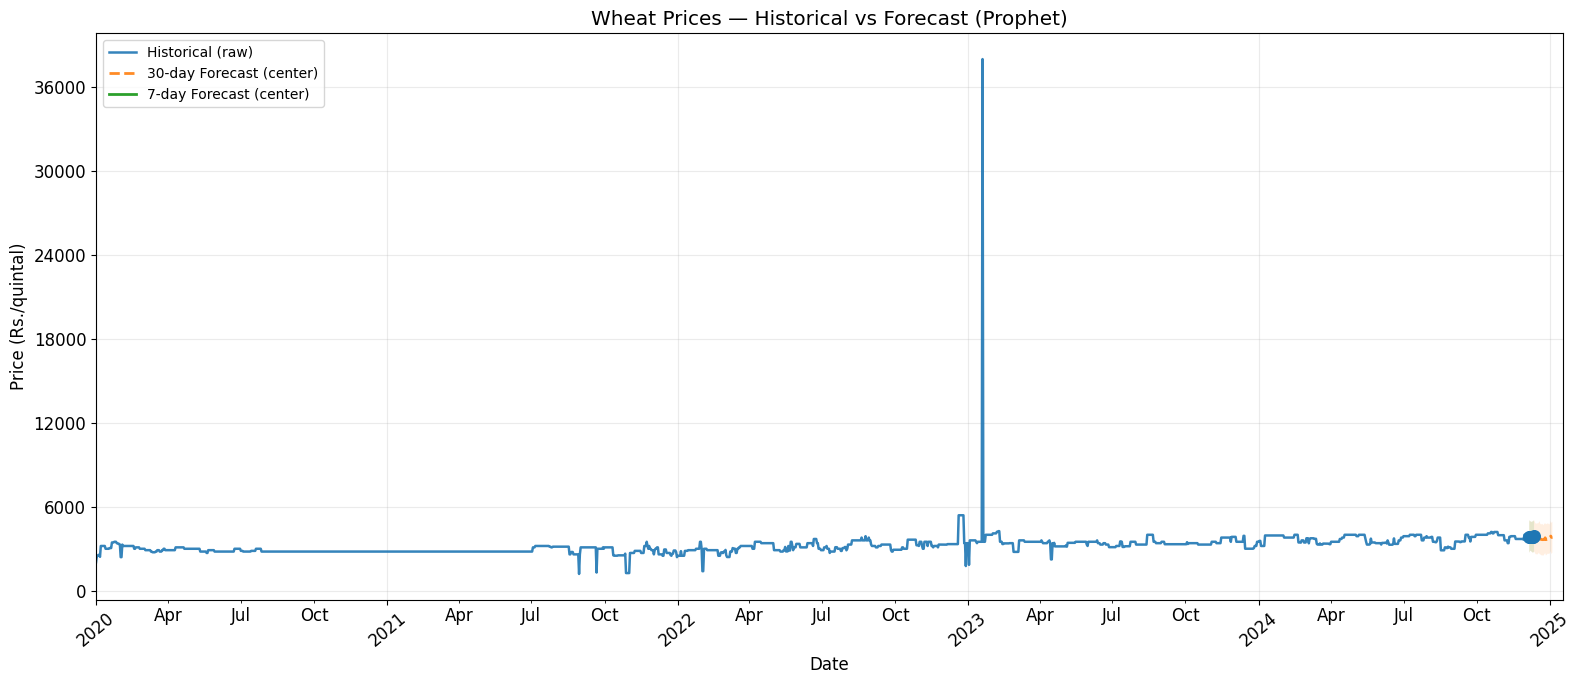

In [10]:
# Improved Prophet plot (clean long-span view)
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Ensure datetime and sorted
df = df.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# fc7 and fc30 should have 'date' and 'predicted' columns.
# If Prophet produced 'yhat', 'yhat_lower', 'yhat_upper' rename accordingly:
# fc7['predicted'] = fc7.get('yhat', fc7.get('predicted'))
# fc30['predicted'] = fc30.get('yhat', fc30.get('predicted'))

for fc in (fc7, fc30):
    fc['date'] = pd.to_datetime(fc['date'])
    fc.sort_values('date', inplace=True)

# Choose time window to display historically (set to None for full range)
# If you want very long history keep None; else set e.g., last_n_days = 365
last_n_days = None  # or 365
if last_n_days is not None:
    start_plot = df.index.max() - pd.Timedelta(days=last_n_days)
    hist_df = df.loc[start_plot:]
else:
    hist_df = df

plt.figure(figsize=(16,7))

# Historical line (thin, no markers)
plt.plot(hist_df.index, hist_df['price'], label='Historical (raw)', linewidth=1.8, alpha=0.9)

# Forecast lines (smooth)
plt.plot(fc30['date'], fc30['predicted'], label='30-day Forecast (center)', linestyle='--', linewidth=2, alpha=0.9)
# Plot markers only for the first 7 points of fc30 to avoid clutter (or for fc7 specifically)
plt.plot(fc7['date'], fc7['predicted'], label='7-day Forecast (center)', linestyle='-', linewidth=2)

# Add markers only for the near-term 7-day forecast (clearer view)
plt.scatter(fc7['date'], fc7['predicted'], s=70, zorder=10)

# If your forecast frames include uncertainty bands (yhat_lower/yhat_upper or predicted_lower/predicted_upper),
# plot them as a translucent fill. Example names attempted below:
def add_conf_band(forecast_df, lower_names=('yhat_lower','predicted_lower'), upper_names=('yhat_upper','predicted_upper')):
    lower = next((c for c in lower_names if c in forecast_df.columns), None)
    upper = next((c for c in upper_names if c in forecast_df.columns), None)
    if lower and upper:
        plt.fill_between(forecast_df['date'], forecast_df[lower], forecast_df[upper], alpha=0.12, linewidth=0)

add_conf_band(fc30)
add_conf_band(fc7)

# Improve x-axis formatting: monthly ticks if long, else auto
ax = plt.gca()
# If full multi-year span, use YearLocator + MonthFormatter; else MonthLocator
total_days = (hist_df.index.max() - hist_df.index.min()).days
if total_days > 800:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
else:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Avoid overlapping ticks and ensure nice integer y ticks
ax.xaxis.set_tick_params(rotation=40)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, prune='both'))

# Expand x-limits slightly beyond last forecast point so end points are clear
last_hist = hist_df.index.max()
last_forecast = max(fc30['date'].max(), fc7['date'].max())
plt.xlim(hist_df.index.min(), last_forecast + pd.Timedelta(days=14))

plt.title('Wheat Prices — Historical vs Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price (Rs./quintal)')
plt.grid(alpha=0.25)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [11]:
# --- Clean Historical Data ---
df = df.copy()
df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.duplicated(keep='first')]  # remove duplicate dates
df = df.dropna(subset=['price'])             # drop rows where price missing
df = df.sort_index()

# --- Clean Forecast Data (fc7, fc30) ---
def clean_forecast(fc):
    fc = fc.copy()
    fc['date'] = pd.to_datetime(fc['date'], errors='coerce')
    fc = fc.dropna(subset=['date','predicted'])
    fc = fc.drop_duplicates(subset=['date'], keep='first')
    return fc.sort_values('date')

fc7 = clean_forecast(fc7)
fc30 = clean_forecast(fc30)

print("Cleaned data ranges:")
print("Historical:", df.index.min(), "→", df.index.max())
print("7-day Forecast:", fc7['date'].min(), "→", fc7['date'].max())
print("30-day Forecast:", fc30['date'].min(), "→", fc30['date'].max())


Cleaned data ranges:
Historical: 2020-01-01 00:00:00 → 2024-12-05 00:00:00
7-day Forecast: 2024-12-06 00:00:00 → 2024-12-12 00:00:00
30-day Forecast: 2024-12-06 00:00:00 → 2025-01-04 00:00:00


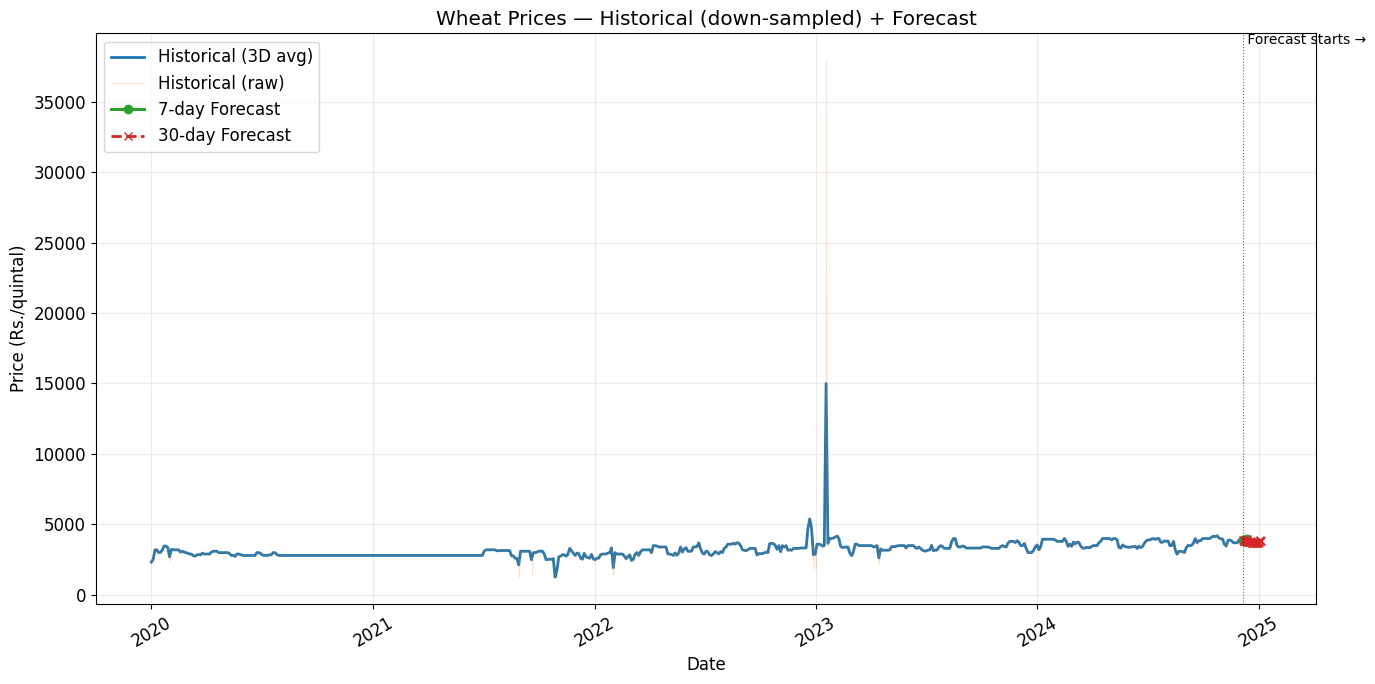

In [12]:
# --- 1) Down-sample long historical series for plotting (keeps original df for modelling/eval) ---
# choose a plotting frequency; '3D' = every 3 days, '7D' = weekly, '1M' = monthly
plot_freq = '3D'
hist_plot_df = df[['price']].resample(plot_freq).mean().dropna()

# keep also a thin full-resolution line if you want (optional)
show_full_line = True

# --- 2) Ensure forecast dfs are prepared: fc7 and fc30 are expected to have columns ['date','predicted'] ---
# (If your forecast columns are named differently, rename to 'date' and 'predicted' first.)
fc7['date']  = pd.to_datetime(fc7['date'], errors='coerce')
fc30['date'] = pd.to_datetime(fc30['date'], errors='coerce')

# --- 3) Plot nicely (no scribbles) ---
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

# historical (down-sampled)
plt.plot(hist_plot_df.index, hist_plot_df['price'], label=f'Historical ({plot_freq} avg)', linewidth=2)

# optional: thin full-resolution background line (comment out if too dense)
if show_full_line:
    plt.plot(df.index, df['price'], linewidth=0.6, alpha=0.25, label='Historical (raw)')

# forecast lines
plt.plot(fc7['date'], fc7['predicted'], marker='o', linestyle='-', linewidth=2.2, label='7-day Forecast')
plt.plot(fc30['date'], fc30['predicted'], marker='x', linestyle='--', linewidth=2.0, label='30-day Forecast')

# make the far future clearer (optional vertical divider)
last_hist = df.index.max()
plt.axvline(last_hist, color='k', linestyle=':', linewidth=0.8, alpha=0.6)
plt.text(last_hist, plt.gca().get_ylim()[1], ' Forecast starts →', va='top', ha='left', fontsize=10)

plt.title('Wheat Prices — Historical (down-sampled) + Forecast')
plt.xlabel('Date')
plt.ylabel('Price (Rs./quintal)')
plt.grid(alpha=0.25)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test MAE: 311.46, RMSE: 380.62, R²: -0.3571


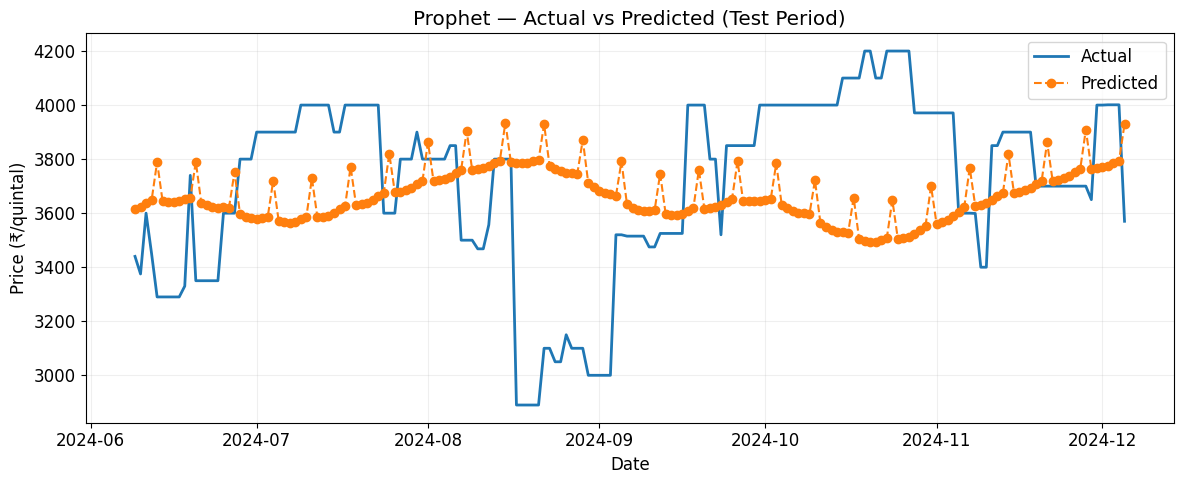